# IMPORT NECESSARY PACKAGES

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import tensorflow
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error

from keras.models import load_model

# LOAD DATA

In [2]:
fpt = pd.read_csv('FPT.csv', parse_dates=True, index_col='Date/Time')
msn = pd.read_csv('MSN.csv', parse_dates=True, index_col='Date/Time')
pnj = pd.read_csv('PNJ.csv', parse_dates=True, index_col='Date/Time')
vic = pd.read_csv('VIC.csv', parse_dates=True, index_col='Date/Time')

stocks = {'fpt':fpt, "msn":msn, 'pnj':pnj, 'vic':vic}

# A FIRST GLANCE AT THE DATASET
Each stock csv file is of the same structure. I choose FPT only for demonstration

In [3]:
fpt.head(3)

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
2018-12-25 09:15:00,FPT,30.89,30.89,30.89,30.89,35410,0
2018-12-25 09:16:00,FPT,30.81,30.81,30.81,30.81,190,0
2018-12-25 09:17:00,FPT,30.74,30.81,30.74,30.74,1120,0


In [4]:
fpt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97406 entries, 2018-12-25 09:15:00 to 2020-12-22 14:46:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Open           97406 non-null  float64
 2   High           97406 non-null  float64
 3   Low            97406 non-null  float64
 4   Close          97406 non-null  float64
 5   Volume         97406 non-null  int64  
 6   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 5.9+ MB


In [5]:
fpt.describe()

,Open,High,Low,Close,Volume,Open Interest
count,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04,97406.0
mean,45.071630,45.090138,45.051430,45.071631,8.044173e+03,0.0
std,6.359803,6.364950,6.354245,6.359799,1.753203e+04,0.0
min,30.250000,30.250000,30.220000,30.250000,1.000000e+01,0.0
25%,39.740000,39.740000,39.700000,39.740000,7.500000e+02,0.0
50%,46.950000,46.950000,46.950000,46.950000,2.960000e+03,0.0
75%,49.200000,49.250000,49.170000,49.200000,8.960000e+03,0.0
max,58.400000,58.500000,58.400000,58.400000,1.255930e+06,0.0


### Check Open Interest column and whether duplicate rows appear or not

In [6]:
for name, stock in stocks.items():
    print(name.upper(), \
          'open interest sum:', stock['Open Interest'].sum(), \
            'duplicate data:', stock.duplicated().sum())

FPT open interest sum: 0 duplicate data: 13811
MSN open interest sum: 0 duplicate data: 27729
PNJ open interest sum: 0 duplicate data: 21684
VIC open interest sum: 0 duplicate data: 25645


### Time Range

In [7]:
for name, stock in stocks.items():
    print(name.upper(), \
          'from', stock.index.min(), \
            'to', stock.index.max())

FPT from 2018-12-25 09:15:00 to 2020-12-22 14:46:00
MSN from 2017-12-25 09:15:00 to 2020-12-22 14:46:00
PNJ from 2018-02-28 09:15:00 to 2020-12-22 14:46:00
VIC from 2018-10-17 09:39:00 to 2020-12-22 14:46:00


### **Insight 1**
- Open interest equals 0 for the whole period, hence we can ignore this feature for now
- No null/duplicate data appeared

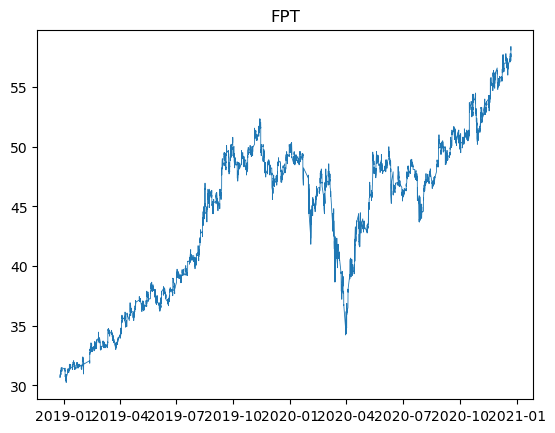

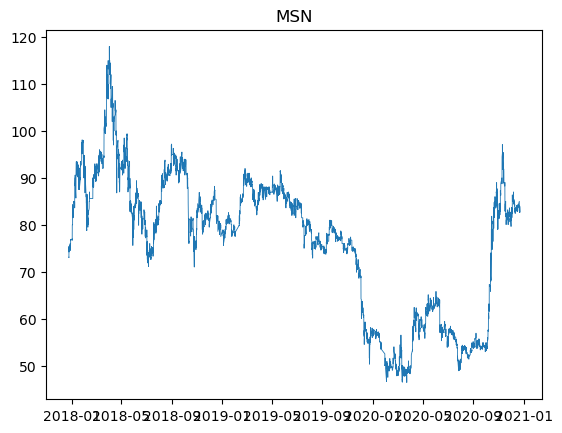

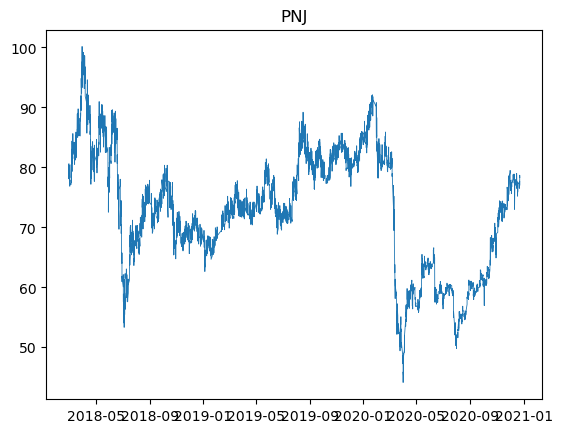

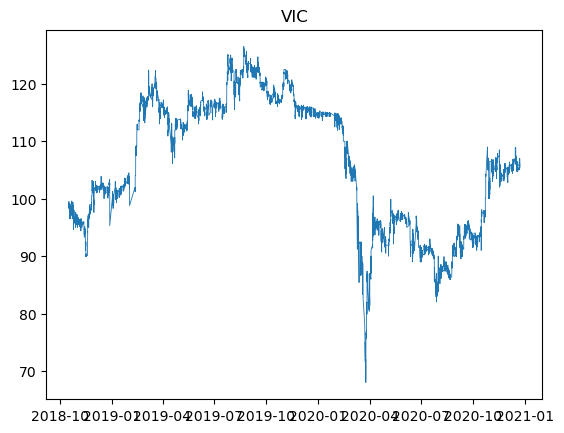

In [8]:
for name,stock in stocks.items():

    plt.plot(stock.index, stock['Close'], linewidth=0.6)
    plt.title(name.upper())
    plt.xticks()
    plt.show()

### **Insight 2**: 

- From stock's characteristics and these above plots, we see that all 4 time series have no seasonality, no cyclicality, no pattern and have no trend apart from FPT stock
- Since tradional time series such as average method, naive, AR or MA models only capture trend or seasonality and stock data contains huge amount of randomness

That is why I will choose machine learning models instead of tradional time series models

# Modeling

### FPT Stock Price Prediction by day

In [9]:
# dự báo biến động giá theo ngày
fpt_by_day = fpt.groupby(fpt.index.strftime('%Y-%m-%d')).agg(\
    {'Open': 'first', 'High': 'max',\
    'Low': 'min', 'Close': 'last',\
    'Volume': 'sum'})
fpt_by_day

,Open,High,Low,Close,Volume
Date/Time,,,,,
2018-12-25,30.89,30.89,30.59,30.66,84960
2018-12-26,31.04,31.22,30.89,30.89,333590
2018-12-27,31.41,31.52,31.19,31.19,454860
2018-12-28,31.34,31.49,31.19,31.49,387170
2019-01-02,31.19,31.45,30.70,30.74,459120
...,...,...,...,...,...
2020-12-16,57.20,57.50,57.00,57.10,1995530
2020-12-17,56.90,57.00,56.00,56.50,3594500
2020-12-18,56.50,57.00,56.50,56.90,1532820


In [10]:
# try predict with only Close column
fpt_close = fpt_by_day['Close'].copy()
fpt_close = fpt_close.reset_index(drop=True)
fpt_close = pd.DataFrame(fpt_close)

In [11]:
class Modeling:
    def __init__(self, model, train, val, test, length, n_outputs, batch_size, n_features, epochs, scaler=None):
        self.model = model
        self.train = train
        self.val = val
        self.test = test
        self.length = length
        self.batch_size = batch_size
        self.n_features = n_features
        self.epochs = epochs
        self.n_outputs = n_outputs
        self.scaler = scaler

        self.train_generator = TimeseriesGenerator(self.train, self.train,\
                                                   length = self.length, batch_size = self.batch_size)
        self.val_generator = TimeseriesGenerator(self.val, self.val,\
                                                length = self.length, batch_size = self.batch_size)

    def fit(self):
        self.model.fit(self.train_generator, validation_data = self.val_generator, epochs = self.epochs,\
                        shuffle = False, callbacks = EarlyStopping(monitor = 'val_loss', patience = 5))
        self.history = self.model.history

    def forecast(self, input_data = None):

        self.forecast = []

        # first_eval_batch = self.train[-length:]
        current_batch = input_data.reshape((1, self.length, self.n_features))


        for i in range(self.n_outputs):
            # get 1st time stamp prediction
            current_pred = self.model.predict(current_batch)[0][0]
            self.forecast.append(current_pred)

            # update batch
            current_batch = np.append(current_batch[:, 1:,: ], [[[current_pred]]], axis=1)

        return self.forecast
    def evaluate(self):
        val_true = self.scaler.inverse_transform(self.val[self.length:]).flatten()
        val_pred = self.scaler.inverse_transform(self.model.predict(self.val_generator)).flatten()

        return f'{mean_absolute_error(val_true, val_pred):.5f}'
    
    def plot(self):
        _, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
        sns.lineplot(x=np.arange(1, len(self.history.history['loss'])+1, 1), \
                     y=self.history.history['mae'], label='Training Loss', color='cornflowerblue', marker='o', ax=ax[0])
        sns.lineplot(x=np.arange(1, len(self.history.history['loss'])+1, 1), \
                     y=self.history.history['val_mae'], label='Validation Loss', color='orange', marker='o', ax=ax[0])

        ax[0].set_title('Model Loss')
        ax[0].set_ylabel('Loss')
        ax[0].set_xlabel('Epochs')
        ax[0].set_xlim([1, self.epochs])
        ax[0].legend(loc='upper right')
        val_data = self.scaler.inverse_transform(self.val).flatten()
        val_true = self.scaler.inverse_transform(self.val[self.length:]).flatten()
        val_pred = self.scaler.inverse_transform(self.model.predict(self.val_generator)).flatten()
        # test_true = self.test[-self.n_outputs:].flatten().tolist()

        sns.lineplot(x = range(len(self.val)), y = val_data, linestyle='dashed', \
                     color='grey', ax = ax[1])
        sns.lineplot(x=range(self.length, len(self.val)), y=val_true, \
                     label='val_true', color='green', marker='o', ax = ax[1])
        sns.lineplot(x=range(int(self.length), len(self.val)), y=val_pred, \
                     label='val_est', color='red', marker='o', ax = ax[1])
        sns.lineplot(x=range(len(self.val), len(self.val)+self.n_outputs), \
                     y=self.scaler.inverse_transform([self.forecast]).flatten(),\
                     label='prediction', color='blue', marker='o', ax = ax[1])

        ax[1].set_title(f'Prediction on Test Dataset with MAE {self.evaluate()}')
    
        plt.tight_layout()
        plt.show()

In [12]:
# Seed value
SEED = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED'] = str(SEED)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Use initializers to initialize model parameters with the same values
INITIALIZER_GLOROT_UNIFORM = tensorflow.keras.initializers.GlorotUniform(seed = SEED)
INITIALIZER_ORTHOGONAL = tensorflow.keras.initializers.Orthogonal(gain = 1.0, seed = SEED)

In [13]:
# train test split
length = 10 # look back window
n_output = 5 # predict stock price after 5 days
train = fpt_close
val = fpt_close[-(length+n_output):] # at least length values needed to predict next time step
test = fpt_close[-length:] # the last 10 days
print(train.shape, val.shape, test.shape)

# scale
scaler = MinMaxScaler()
scaler.fit(train)
val_scaled = scaler.transform(val)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

(499, 1) (15, 1) (10, 1)


In [14]:
batch_size = 32 
epochs = 20
n_features = 1
units = 50
layer = 5
input_shape = (length, n_features)

model = Sequential()
model.add(SimpleRNN(units, input_shape = input_shape,\
                    kernel_initializer    = INITIALIZER_GLOROT_UNIFORM, 
                    recurrent_initializer = INITIALIZER_ORTHOGONAL,\
                        return_sequences=True))
model.add(Dropout(0.2, seed = SEED))

model.add(SimpleRNN(units, input_shape = input_shape,\
                    kernel_initializer    = INITIALIZER_GLOROT_UNIFORM, 
                    recurrent_initializer = INITIALIZER_ORTHOGONAL,\
                        return_sequences=False))
model.add(Dropout(0.2, seed = SEED))
model.add(Dense(1, kernel_initializer = INITIALIZER_GLOROT_UNIFORM))
model.compile(optimizer = 'adam', loss = 'mse', metrics='mae')

algo_rnn = Modeling(model, train_scaled, val_scaled, test_scaled,\
                    length, n_output, batch_size, n_features, epochs,scaler)

algo_rnn.fit()
algo_rnn.forecast(test.to_numpy())
algo_rnn.model.save(f'RNN_mae_{algo_rnn.evaluate()}_{units}_{length}_{epochs}_{layer}')
# del model
# model = load_model('RNN_mae_5.82961_50_10_200_5')



Epoch 1/20

16/16 [==============================] - 3s 33ms/step - loss: 0.1449 - mae: 0.2989 - val_loss: 0.1053 - val_mae: 0.3232
Epoch 2/20
16/16 [==============================] - 0s 7ms/step - loss: 0.1193 - mae: 0.2819 - val_loss: 0.0252 - val_mae: 0.1559
Epoch 3/20
16/16 [==============================] - 0s 8ms/step - loss: 0.0583 - mae: 0.1859 - val_loss: 0.0042 - val_mae: 0.0580
Epoch 4/20
16/16 [==============================] - 0s 8ms/step - loss: 0.0618 - mae: 0.1991 - val_loss: 8.7783e-04 - val_mae: 0.0246
Epoch 5/20
16/16 [==============================] - 0s 7ms/step - loss: 0.0713 - mae: 0.2125 - val_loss: 0.0025 - val_mae: 0.0414
Epoch 6/20
16/16 [==============================] - 0s 8ms/step - loss: 0.0616 - mae: 0.1921 - val_loss: 0.0137 - val_mae: 0.1136
Epoch 7/20
16/16 [==============================] - 0s 8ms/step - loss: 0.0328 - mae: 0.1379 - val_loss: 0.0058 - val_mae: 0.0714
Epoch 8/20
16/16 [==============================] - 0s 8ms/step - loss: 0.0270 - m

INFO:tensorflow:Assets written to: RNN_mae_1.38944_50_10_20_5\assets


1/1 [==============================] - 0s 45ms/step


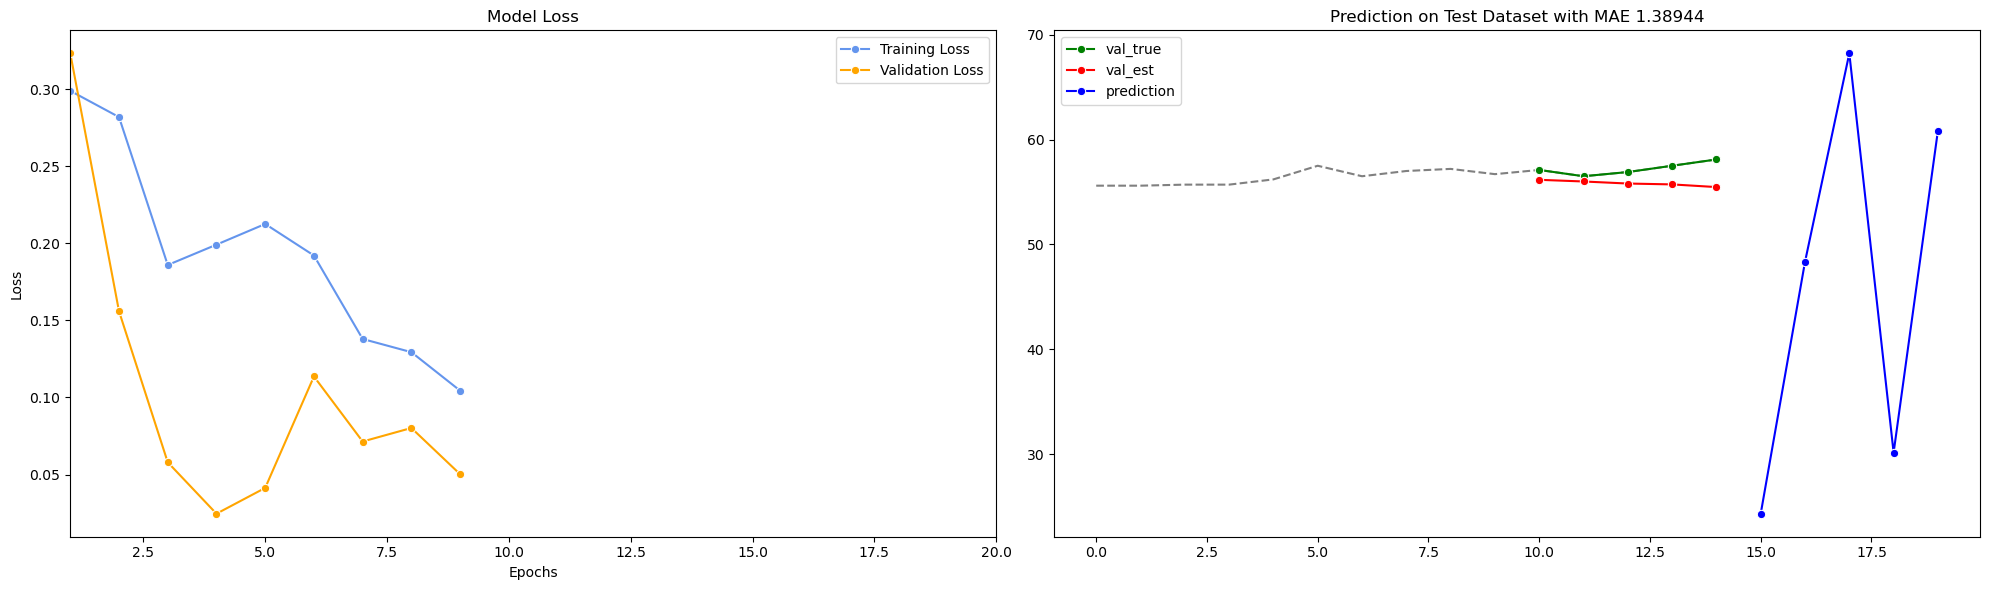

In [15]:
algo_rnn.plot()

## LSTM

In [16]:
# train test split
length = 10 # look back window
n_output = 5 # predict stock price after 5 days
train = fpt_close
val = fpt_close[-(length+n_output):] # at least length values needed to predict next time step
test = fpt_close[-length:] # the last 10 days
print(train.shape, val.shape, test.shape)

# scale
scaler = MinMaxScaler()
scaler.fit(train)
val_scaled = scaler.transform(val)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

(499, 1) (15, 1) (10, 1)


In [17]:
batch_size = 32 
epochs = 9
n_features = 1
units = 20
layer = 5
input_shape = (length, n_features)

model = Sequential()
model.add(LSTM(units, input_shape = input_shape,\
                    kernel_initializer    = INITIALIZER_GLOROT_UNIFORM, 
                    recurrent_initializer = INITIALIZER_ORTHOGONAL,\
                        return_sequences=True))
model.add(Dropout(0.2, seed=SEED))
model.add(LSTM(units, input_shape = input_shape,\
                    kernel_initializer    = INITIALIZER_GLOROT_UNIFORM, 
                    recurrent_initializer = INITIALIZER_ORTHOGONAL,\
                        return_sequences=False))
model.add(Dropout(0.3, seed=SEED))
model.add(Dense(1, kernel_initializer = INITIALIZER_GLOROT_UNIFORM))
model.compile(optimizer = 'adam', loss = 'mse', metrics='mae')

algo_lstm = Modeling(model, train_scaled, val_scaled, test_scaled,\
                    length, n_output, batch_size, n_features, epochs,scaler)

algo_lstm.fit()
algo_lstm.forecast(test.to_numpy())
algo_lstm.model.save(f'LSTM_mae_{algo_lstm.evaluate()}_{units}_{length}_{epochs}_{layer}')
# del model


Epoch 1/9
16/16 [==============================] - 5s 88ms/step - loss: 0.1349 - mae: 0.3328 - val_loss: 0.1837 - val_mae: 0.4282
Epoch 2/9
16/16 [==============================] - 0s 13ms/step - loss: 0.0215 - mae: 0.1153 - val_loss: 0.0083 - val_mae: 0.0895
Epoch 3/9
16/16 [==============================] - 0s 14ms/step - loss: 0.0303 - mae: 0.1452 - val_loss: 0.0422 - val_mae: 0.2047
Epoch 4/9
16/16 [==============================] - 0s 14ms/step - loss: 0.0176 - mae: 0.1060 - val_loss: 0.0237 - val_mae: 0.1530
Epoch 5/9
16/16 [==============================] - 0s 13ms/step - loss: 0.0176 - mae: 0.1060 - val_loss: 0.0100 - val_mae: 0.0988
Epoch 6/9
16/16 [==============================] - 0s 12ms/step - loss: 0.0149 - mae: 0.0964 - val_loss: 0.0115 - val_mae: 0.1061
Epoch 7/9
16/16 [==============================] - 0s 15ms/step - loss: 0.0140 - mae: 0.0884 - val_loss: 0.0055 - val_mae: 0.0726
Epoch 8/9
16/16 [==============================] - 0s 12ms/step - loss: 0.0119 - mae: 0.08

INFO:tensorflow:Assets written to: LSTM_mae_0.71816_20_10_9_5\assets


1/1 [==============================] - 0s 47ms/step


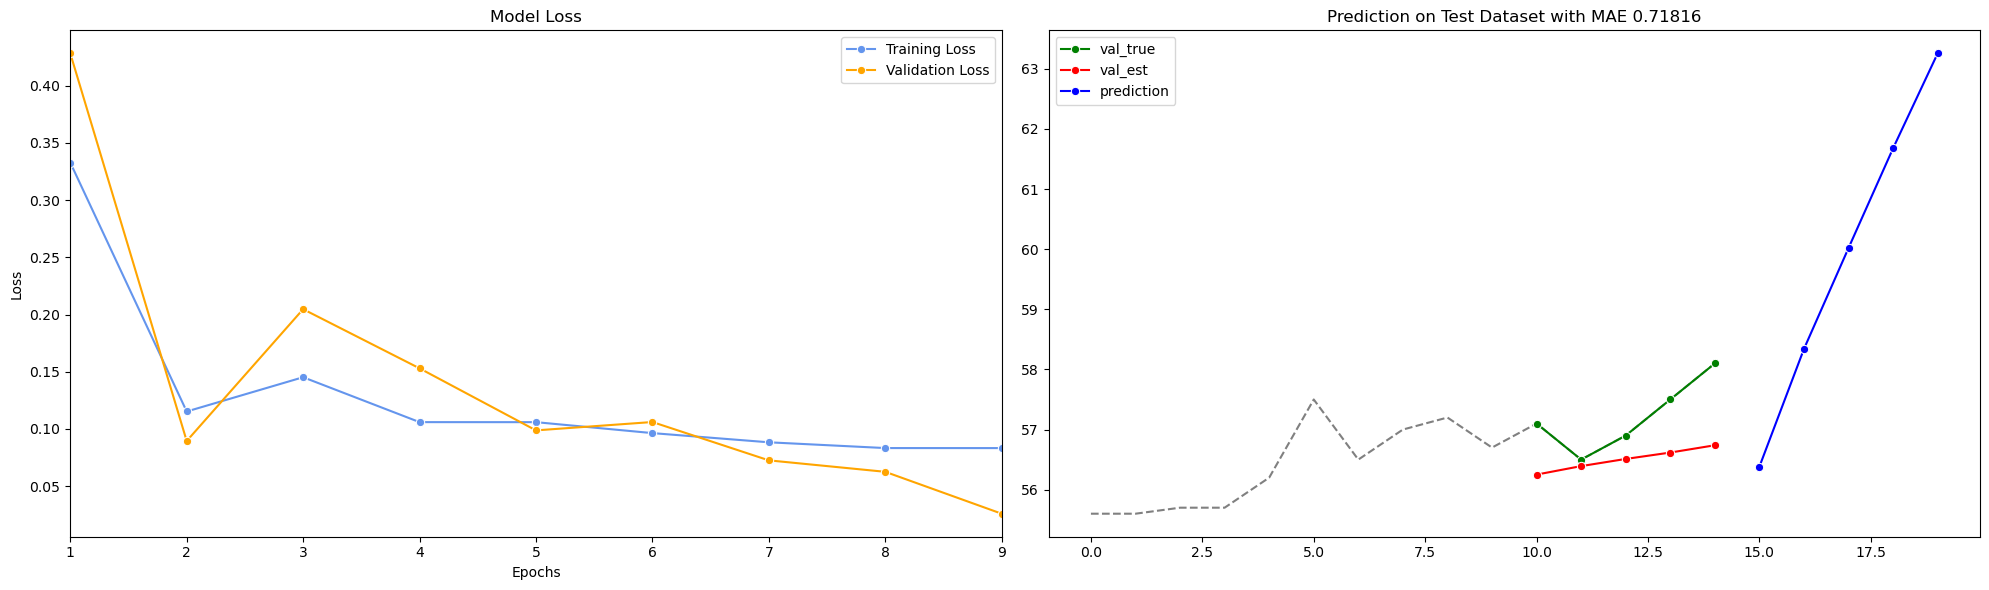

In [18]:
algo_lstm.plot()